In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
def load_preprocess():
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    return pickle.load(open('preprocess.dat', mode='rb'))


def batch_data(words, sequence_length, batch_size):
    """
    Batch the neural network data using DataLoader
    :param words: The word ids of the Book scripts
    :param sequence_length: The sequence length of each batch
    :param batch_size: The size of each batch; the number of sequences in a batch
    :return: DataLoader with batched data
    """
    # Get number of batches
    num_batches = len(words) // batch_size
    # Only consider words that would fit into full batches
    trimmed_words = words[:num_batches * batch_size]
    # Determine last index to have full sequences
    final_idx = len(trimmed_words) - sequence_length
    x, y = [], []
    for idx in range(final_idx):
        idx_end = idx + sequence_length
        x_batch = trimmed_words[idx:idx_end]
        x.append(x_batch)
        y_batch = trimmed_words[idx_end]
        y.append(y_batch)
    
    data = TensorDataset(torch.from_numpy(np.asarray(x)), torch.from_numpy(np.asarray(y)))
    data_loader = DataLoader(data, shuffle=True, batch_size=batch_size)
    return data_loader


def save_model(filename, decoder):
    save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
    torch.save(decoder, save_filename)


def load_model(filename):
    save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
    return torch.load(save_filename)

In [3]:
class RNN(nn.Module):
    
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.5):
        """
        Initialize the PyTorch RNN Module
        :param vocab_size: The number of input dimensions of the neural network (the size of the vocabulary)
        :param output_size: The number of output dimensions of the neural network
        :param embedding_dim: The size of embeddings, should you choose to use them        
        :param hidden_dim: The size of the hidden layer outputs
        :param dropout: dropout to add in between LSTM/GRU layers
        """
        super(RNN, self).__init__()
        
        # set class variables
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # define model layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)
    
    
    def forward(self, nn_input, hidden):
        """
        Forward propagation of the neural network
        :param nn_input: The input to the neural network
        :param hidden: The hidden state        
        :return: Two Tensors, the output of the neural network and the latest hidden state
        """
        batch_size = nn_input.size(0)
        
        embed = self.embedding(nn_input.long())
        lstm_out, hidden = self.lstm(embed, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.fc(lstm_out)
        out = out.view(batch_size, -1, self.output_size)
        out = out[:, -1]

        # return one batch of output word scores and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        '''
        Initialize the hidden state of an LSTM/GRU
        :param batch_size: The batch_size of the hidden state
        :return: hidden state of dims (n_layers, batch_size, hidden_dim)
        '''
        # Implement function
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        # initialize hidden state with zero weights, and move to GPU if available
        
        return hidden

In [4]:
def forward_back_prop(rnn, optimizer, criterion, inp, target, hidden):
    """
    Forward and backward propagation on the neural network
    :param rnn: The PyTorch Module that holds the neural network
    :param optimizer: The PyTorch optimizer for the neural network
    :param criterion: The PyTorch loss function
    :param inp: A batch of input to the neural network
    :param target: The target output for the batch of input
    :return: The loss and the latest hidden state Tensor
    """
    # move data to GPU, if available
    if(train_on_gpu):
        rnn.cuda()
    
    # perform backpropagation and optimization
    h = tuple([h_tmp.data for h_tmp in hidden])
    
    # Zero out gradients
    rnn.zero_grad()
    
    # Copy to GPU
    if(train_on_gpu):
        inp, target = inp.cuda(), target.type(torch.LongTensor).cuda()
        
    # Predict output
    output, h = rnn(inp, h)
    
    # Calc loss
    # loss = criterion(output, target)
    loss = criterion(output, target)
    loss.backward()
    
    # Prevent exploding gradient with RNN/LSTM
    nn.utils.clip_grad_norm_(rnn.parameters(), 4)
    
    optimizer.step()

    # return the loss over a batch and the hidden state produced by our model
    return loss.item(), h

In [5]:
def train_rnn(rnn, batch_size, optimizer, criterion, n_epochs, show_every_n_batches=100):
    losses = []
    batch_losses = []
    
    rnn.train()

    print("Training for %d epoch(s)..." % n_epochs)
    for epoch_i in range(1, n_epochs + 1):
        print(f"Epoch {epoch_i}")
        
        # initialize hidden state
        hidden = rnn.init_hidden(batch_size)
        
        for batch_i, (inputs, labels) in enumerate(train_loader, 1):
            # print(f"Epoch {epoch_i} | Batch {batch_i}")
            
            # make sure you iterate over completely full batches, only
            n_batches = len(train_loader.dataset)//batch_size
            if(batch_i > n_batches):
                break
            
            # forward, back prop
            loss, hidden = forward_back_prop(rnn, optimizer, criterion, inputs, labels, hidden)          
            # record loss
            batch_losses.append(loss)

            # printing loss stats
            if batch_i % show_every_n_batches == 0:
                print(f'\tEpoch: {epoch_i:>4}/{n_epochs:<4}  Loss: {np.average(batch_losses)}')
                losses.append(np.average(batch_losses))
                batch_losses = []

    # returns a trained rnn
    return rnn, losses

In [6]:
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')

In [7]:
int_text, vocab_to_int, int_to_vocab, token_dict = load_preprocess()

In [8]:
test_text = range(50)
t_loader = batch_data(test_text, sequence_length=5, batch_size=10)

data_iter = iter(t_loader)
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

torch.Size([10, 5])
tensor([[ 1,  2,  3,  4,  5],
        [14, 15, 16, 17, 18],
        [28, 29, 30, 31, 32],
        [44, 45, 46, 47, 48],
        [17, 18, 19, 20, 21],
        [19, 20, 21, 22, 23],
        [36, 37, 38, 39, 40],
        [15, 16, 17, 18, 19],
        [33, 34, 35, 36, 37],
        [13, 14, 15, 16, 17]], dtype=torch.int32)

torch.Size([10])
tensor([ 6, 19, 33, 49, 22, 24, 41, 20, 38, 18], dtype=torch.int32)


In [9]:
# Data params
# Sequence Length
sequence_length = 20  # of words in a sequence
# Batch Size
batch_size = 128

# data loader - do not change
train_loader = batch_data(int_text, sequence_length, batch_size)

In [10]:
# Training parameters
# Number of Epochs
num_epochs = 50
# Learning Rate
learning_rate = 0.001

# Model parameters
# Vocab size
vocab_size = len(vocab_to_int)
# Output size
output_size = vocab_size
# Embedding Dimension
embedding_dim = 200
# Hidden Dimension
hidden_dim = 256
# Number of RNN Layers
n_layers = 2

# Show stats for every n number of batches
show_every_n_batches = 500

In [11]:
# create model and move to gpu if available
rnn = RNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.5)
if train_on_gpu:
    rnn.cuda()

# defining loss and optimization functions for training
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# training the model
trained_rnn, loss = train_rnn(rnn, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

Training for 50 epoch(s)...
Epoch 1
	Epoch:    1/50    Loss: 6.692838034629822
	Epoch:    1/50    Loss: 6.269230317115784
	Epoch:    1/50    Loss: 6.04715196800232
	Epoch:    1/50    Loss: 5.9450034379959105
	Epoch:    1/50    Loss: 5.865376475334167
	Epoch:    1/50    Loss: 5.789781674385071
	Epoch:    1/50    Loss: 5.7467555913925175
	Epoch:    1/50    Loss: 5.710786415100098
	Epoch:    1/50    Loss: 5.662838299751281
	Epoch:    1/50    Loss: 5.616340503692627
	Epoch:    1/50    Loss: 5.599313571929931
	Epoch:    1/50    Loss: 5.560633892059326
Epoch 2
	Epoch:    2/50    Loss: 5.442950360954306
	Epoch:    2/50    Loss: 5.3926104078292845
	Epoch:    2/50    Loss: 5.375588607788086
	Epoch:    2/50    Loss: 5.366182539939881
	Epoch:    2/50    Loss: 5.353274345397949
	Epoch:    2/50    Loss: 5.338656592369079
	Epoch:    2/50    Loss: 5.337219166755676
	Epoch:    2/50    Loss: 5.3216510543823246
	Epoch:    2/50    Loss: 5.319103585243225
	Epoch:    2/50    Loss: 5.2957671995162965
	Epoch

	Epoch:   16/50    Loss: 4.228574073314666
	Epoch:   16/50    Loss: 4.255858575820922
	Epoch:   16/50    Loss: 4.259651049137116
	Epoch:   16/50    Loss: 4.264527567863464
	Epoch:   16/50    Loss: 4.273568674564362
	Epoch:   16/50    Loss: 4.301086458683014
Epoch 17
	Epoch:   17/50    Loss: 4.126284969550321
	Epoch:   17/50    Loss: 4.1053393983840945
	Epoch:   17/50    Loss: 4.103457525730133
	Epoch:   17/50    Loss: 4.128394444942474
	Epoch:   17/50    Loss: 4.158969497680664
	Epoch:   17/50    Loss: 4.165053059577942
	Epoch:   17/50    Loss: 4.194871358394622
	Epoch:   17/50    Loss: 4.19663843870163
	Epoch:   17/50    Loss: 4.227120222091675
	Epoch:   17/50    Loss: 4.2468961906433105
	Epoch:   17/50    Loss: 4.248178778648376
	Epoch:   17/50    Loss: 4.266205548286438
Epoch 18
	Epoch:   18/50    Loss: 4.107194478465322
	Epoch:   18/50    Loss: 4.048713207244873
	Epoch:   18/50    Loss: 4.084457123756409
	Epoch:   18/50    Loss: 4.110441961765289
	Epoch:   18/50    Loss: 4.12604587

	Epoch:   32/50    Loss: 3.8696814924893603
	Epoch:   32/50    Loss: 3.842768452167511
	Epoch:   32/50    Loss: 3.85341836977005
	Epoch:   32/50    Loss: 3.8797004890441893
	Epoch:   32/50    Loss: 3.8970921664237976
	Epoch:   32/50    Loss: 3.9182410521507265
	Epoch:   32/50    Loss: 3.9383519921302796
	Epoch:   32/50    Loss: 3.957512380123138
	Epoch:   32/50    Loss: 3.974120273590088
	Epoch:   32/50    Loss: 4.007708135604858
	Epoch:   32/50    Loss: 3.9918698616027832
	Epoch:   32/50    Loss: 4.011325295925141
Epoch 33
	Epoch:   33/50    Loss: 3.859448933335732
	Epoch:   33/50    Loss: 3.828968981266022
	Epoch:   33/50    Loss: 3.851298785209656
	Epoch:   33/50    Loss: 3.8810183396339415
	Epoch:   33/50    Loss: 3.8943512268066405
	Epoch:   33/50    Loss: 3.920953032016754
	Epoch:   33/50    Loss: 3.9097440304756166
	Epoch:   33/50    Loss: 3.9437841734886168
	Epoch:   33/50    Loss: 3.952465356826782
	Epoch:   33/50    Loss: 3.969167974472046
	Epoch:   33/50    Loss: 3.991802806

	Epoch:   47/50    Loss: 3.7926476306915284
	Epoch:   47/50    Loss: 3.8100808572769167
	Epoch:   47/50    Loss: 3.8128470487594606
	Epoch:   47/50    Loss: 3.8279855909347535
	Epoch:   47/50    Loss: 3.840764820098877
	Epoch:   47/50    Loss: 3.8656172556877135
	Epoch:   47/50    Loss: 3.8770635418891906
Epoch 48
	Epoch:   48/50    Loss: 3.7297622184567465
	Epoch:   48/50    Loss: 3.6957771711349485
	Epoch:   48/50    Loss: 3.7188016238212587
	Epoch:   48/50    Loss: 3.743734484195709
	Epoch:   48/50    Loss: 3.7576294927597047
	Epoch:   48/50    Loss: 3.7890750665664674
	Epoch:   48/50    Loss: 3.7982600884437563
	Epoch:   48/50    Loss: 3.8051732048988343
	Epoch:   48/50    Loss: 3.8262466049194335
	Epoch:   48/50    Loss: 3.8372292265892027
	Epoch:   48/50    Loss: 3.871657735347748
	Epoch:   48/50    Loss: 3.8890133805274965
Epoch 49
	Epoch:   49/50    Loss: 3.730587804549916
	Epoch:   49/50    Loss: 3.6714827566146853
	Epoch:   49/50    Loss: 3.7045059514045717
	Epoch:   49/50   

In [12]:
# saving the trained model
save_model('./save/trained_rnn_trimmed', trained_rnn)
print('Model Trained and Saved')

C:\Users\14196\Anaconda3\envs\ml37\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Model Trained and Saved


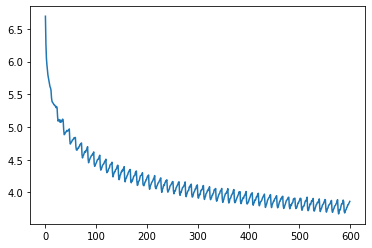

In [13]:
plt.plot(loss)